# Utiliser un modèle de Deep Learning pour apprendre la classification d'images (CIFAR-10)


Soit le jeu de données [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) :

In [4]:
import keras
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('dimensions de X_train :', X_train.shape)
print(X_train.shape[0], " images d'apprentissage")
print(X_test.shape[0], " images de test")
num_classes = max(y_train.max(), y_test.max())+1
print(num_classes, " classes")

# classification multi-labels → attrributs cibles binaires
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


2023-11-24 15:45:10.158295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


170498071/170498071 [==============================] - 18s 0us/step
dimensions de X_train : (50000, 32, 32, 3)
50000  images d'apprentissage
10000  images de test
10  classes


On a donc 50000 images d'entrainement et 10000 images de test, de dimensions 32×32 sur 3 canaux de coulers (R,G,B) et 10 classes.

On regarde l'intervalle de valeurs prises par les données et le type de celles-ci.

In [2]:
X_train.min(), X_train.max()

(0, 255)

In [3]:
X_train.dtype

dtype('uint8')

On convertit les doénnes en nombres à virgules flottante sur l'intervalle ```[0., 1.]``` :

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

On utilisera ce jeu de données pour une tâche de classification supervisée (les noms des classes [sont disponibles ici](https://www.cs.toronto.edu/~kriz/cifar.html)) :

In [3]:
labels=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

On visualise un petit échantillon des images :

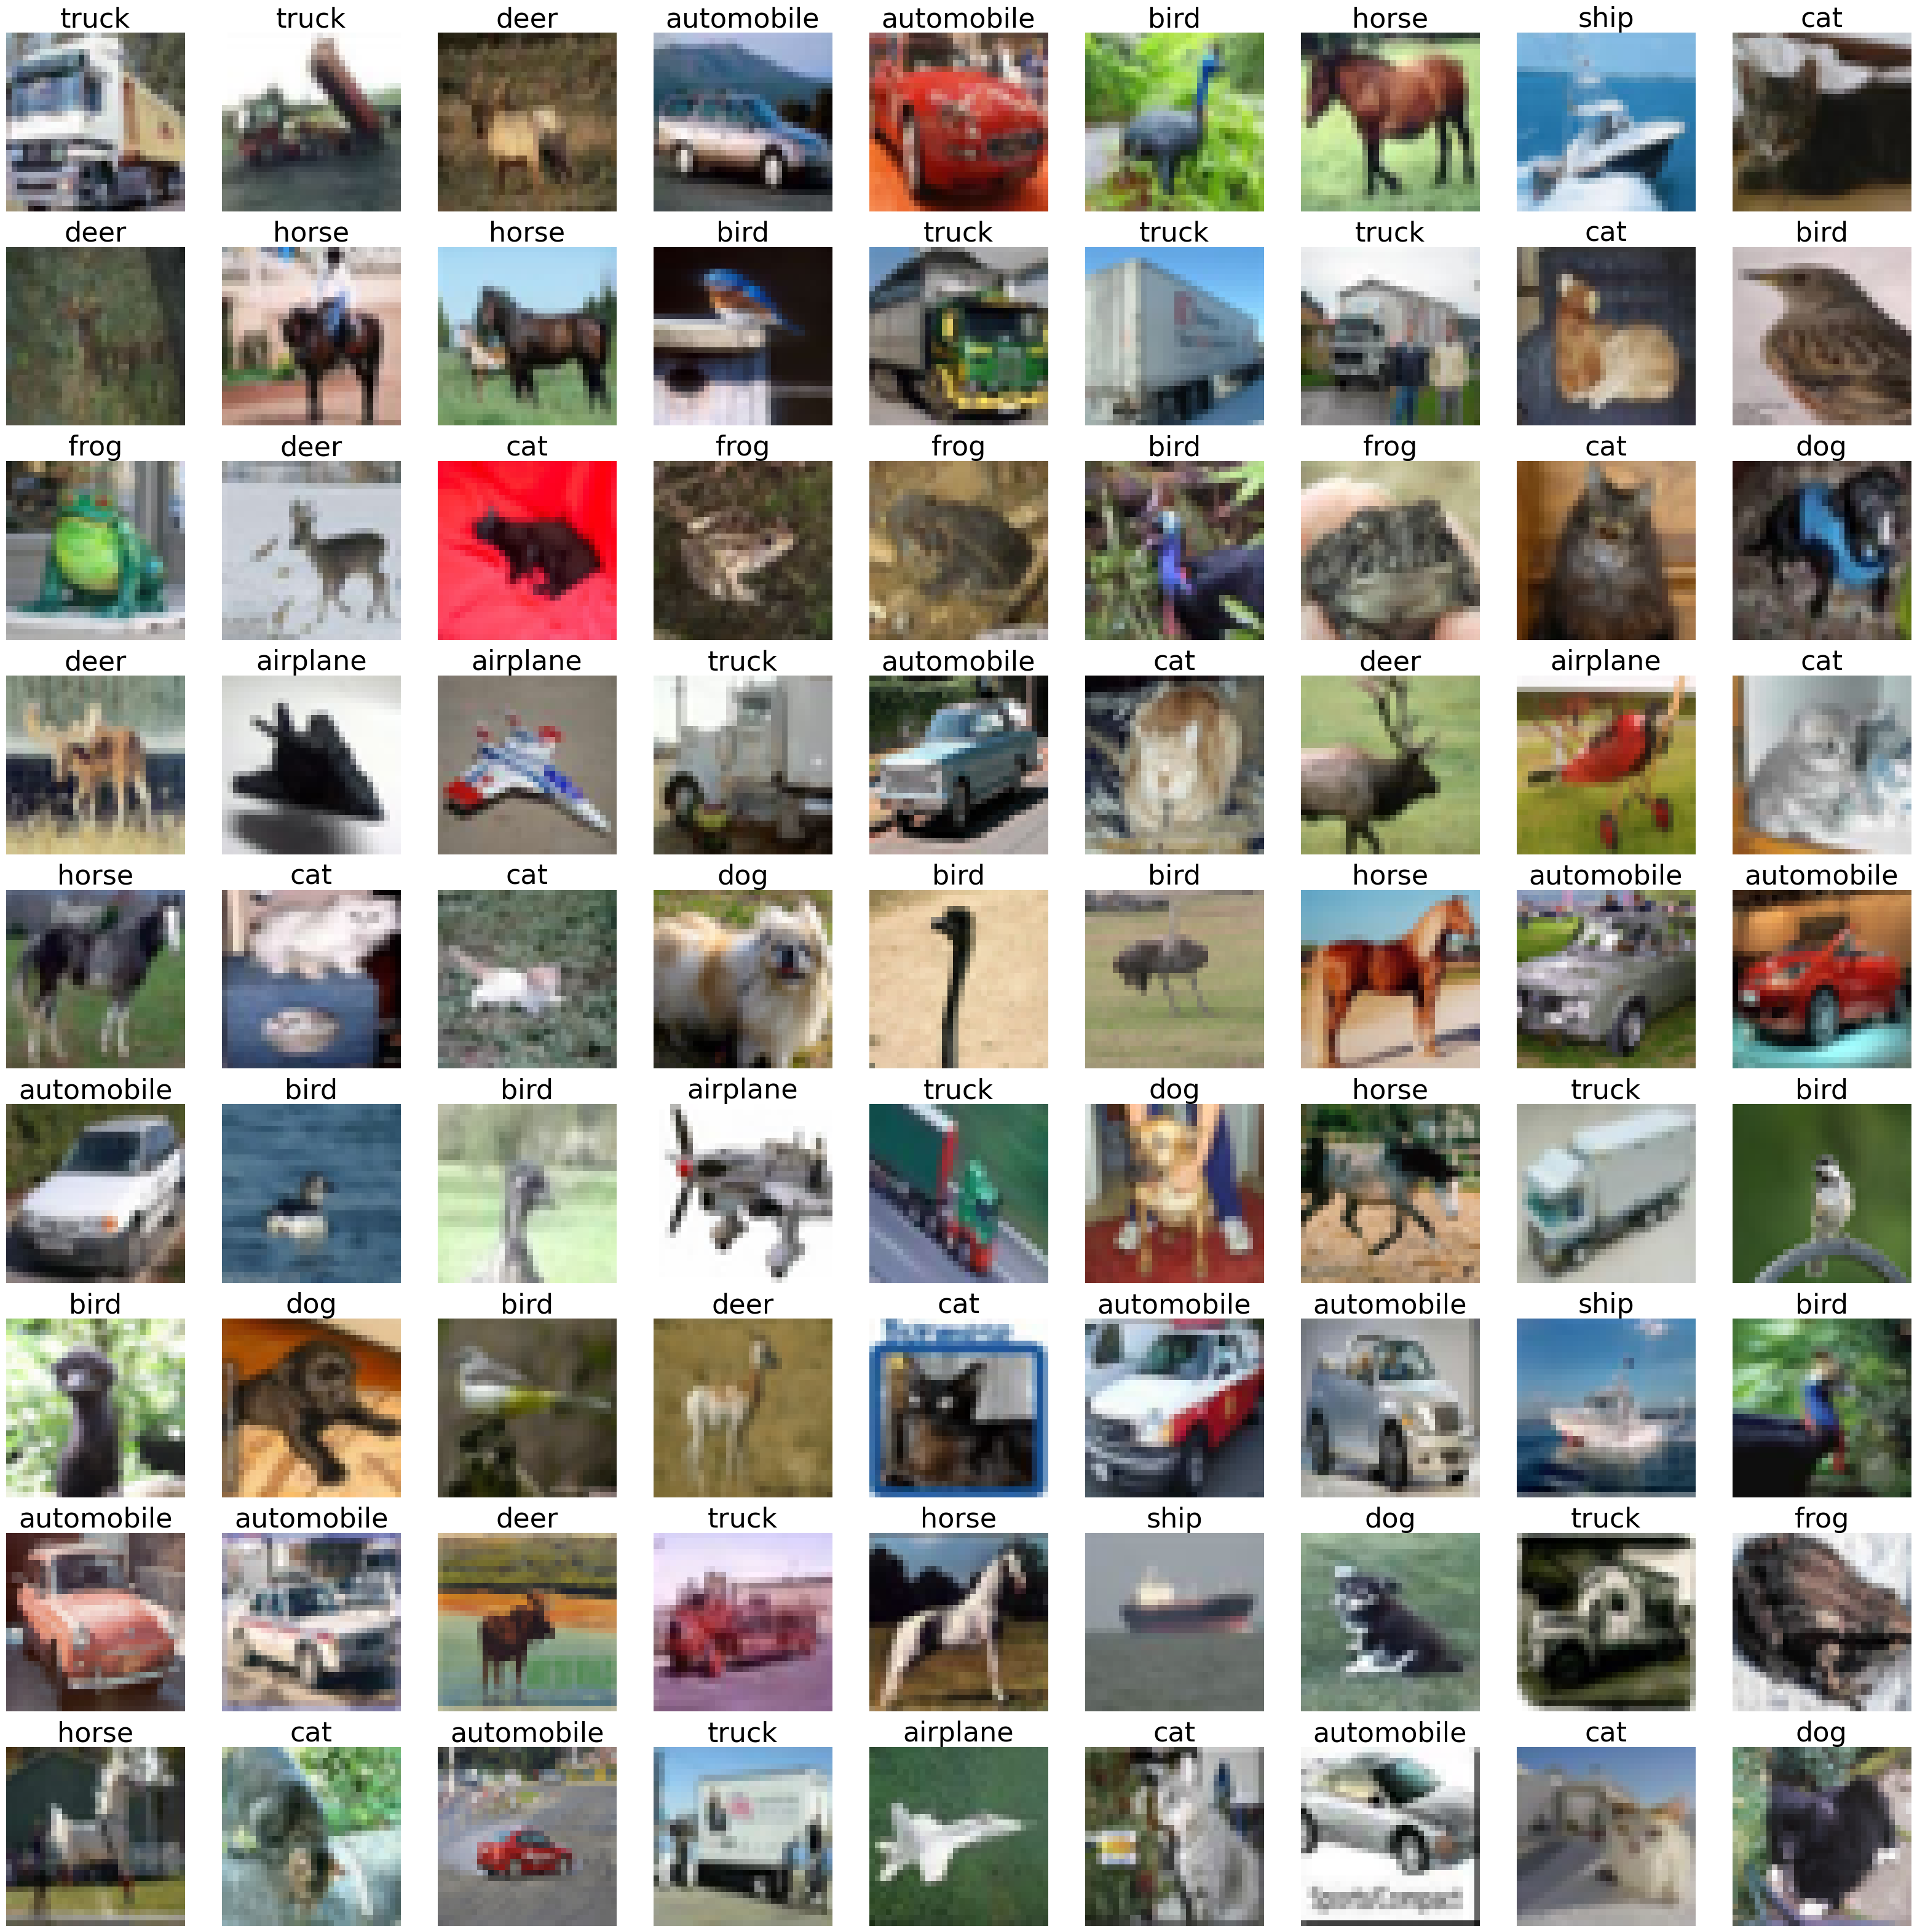

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(40,40))
for i in range(1,9*9+1):
    plt.subplot(9,9, i)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(labels[np.argmax(y_train[i], axis=0)], fontsize=32) #np.argmax parce qu'y_train est en one-hot-encoding 
plt.show()

## Utiliser un modèle appris 'from scratch'

On peut commencer par essayer d'utiliser un perceptron multi-couches:

Pour un perceptron multi-couches, on n'utilise pas la structure 2D des images et l'on commence donc par 'aplatir' les données 2D en 1D avec une couche [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/).

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import SGD

def build_mlpc_model(width, height, depth, n_classes):
    (input_shape, chan_dim) = ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" else ((height, width, depth), -1)
    model = Sequential()
    model.add(Flatten(input_shape=input_shape,))
    model.add(Dense(width*height*depth, activation="relu"))
    model.add(Dense(n_classes, activation="relu"))
    model.add(Dense(n_classes, activation="softmax"))
    model.add(Dense(n_classes, activation ="softmax"))
    return model

On instancie ce modèle et le compile avec un optimiseur.

In [19]:
import tensorflow as tf
width, height, depth= X_train.shape[1:]
n_classes= y_train.shape[1]
model= build_mlpc_model(width, height, depth, n_classes)
opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

On peut afficher une description sous forme texte du modèle qui indique les types de couches, leurs tailles et les nombres de paramètres avec la méthode [summary](https://keras.io/api/models/model/#summary-method) :

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_5 (Dense)             (None, 3072)              9440256   
                                                                 
 dense_6 (Dense)             (None, 10)                30730     
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                                 
Total params: 9471206 (36.13 MB)
Trainable params: 9471206 (36.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


On peut aussi générerune représentation graphique de ce modèle avec [plot_model](https://keras.io/api/utils/model_plotting_utils/):

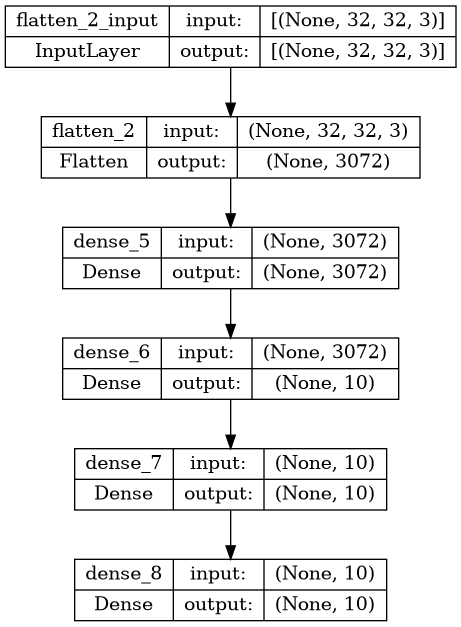

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Comme il y a beaucoup de paramètres, l'entrainement est long : avec environ 300 ms par étape sur un CPU (une image du jeu d'apprentissage), cela prend environ 2h30 !

In [35]:
%%time
history_mlp=model.fit(X_train, y_train, validation_split=0.2, epochs=25, batch_size=32)

2023-11-18 08:57:26.863393: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/25
1250/1250 [==============================] - 387s 309ms/step - loss: 2.2191 - accuracy: 0.2062 - val_loss: 2.2061 - val_accuracy: 0.2096
Epoch 2/25
1250/1250 [==============================] - 364s 291ms/step - loss: 2.1859 - accuracy: 0.2157 - val_loss: 2.1831 - val_accuracy: 0.2140
Epoch 3/25
1250/1250 [==============================] - 395s 316ms/step - loss: 2.1525 - accuracy: 0.2189 - val_loss: 2.1459 - val_accuracy: 0.2192
Epoch 4/25
1250/1250 [==============================] - 331s 265ms/step - loss: 2.1226 - accuracy: 0.2232 - val_loss: 2.1397 - val_accuracy: 0.2096
Epoch 5/25
1250/1250 [==============================] - 324s 259ms/step - loss: 2.0921 - accuracy: 0.2264 - val_loss: 2.0865 - val_accuracy: 0.2199
Epoch 6/25
1250/1250 [==============================] - 329s 264ms/step - loss: 2.0610 - accuracy: 0.2297 - val_loss: 2.0494 - val_accuracy: 0.2310
Epoch 7/25
1250/1250 [==============================] - 326s 261ms/step - loss: 2.0320 - accuracy: 0.2336 - val_

Évaluation sur le jeu de test :
Les résultats sont très décevants !

313/313 [==============================] - 2s 7ms/step


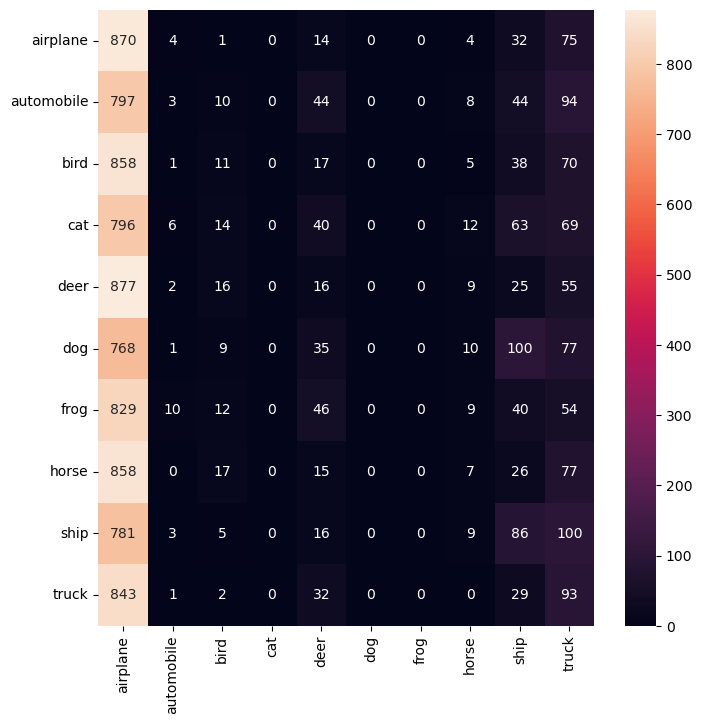

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions  = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(1),predictions.argmax(1)) #argmax pour one-hot encoding → № de classe
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,  xticklabels=labels, yticklabels = labels, fmt='d');

Les résultats sont très décevants.

## ConvNet

On peut commencer par ajouter des couches de convolution.
Définition :

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import SGD

def build_conv_model(width, height, depth, n_classes):
    (input_shape, chan_dim) = ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" else ((height, width, depth), -1)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(n_classes, activation='softmax'))
    return model

Instanciation :

In [41]:
width, height, depth= X_train.shape[1:]
n_classes= y_train.shape[1]
model_2= build_conv_model(width, height, depth, n_classes)
opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)

model_2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Visualisation des modèles (texte et graphique):

In [61]:
# À faire

Apprentissage :

In [38]:
%%time
history_conv=model_2.fit(X_train, y_train, validation_split=0.2, epochs=25, batch_size=32)

2023-11-18 12:13:20.456090: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/25
1250/1250 [==============================] - 55s 43ms/step - loss: 1.7231 - accuracy: 0.3819 - val_loss: 1.5490 - val_accuracy: 0.4458
Epoch 2/25
1250/1250 [==============================] - 50s 40ms/step - loss: 1.4305 - accuracy: 0.4919 - val_loss: 1.3992 - val_accuracy: 0.5115
Epoch 3/25
1250/1250 [==============================] - 49s 39ms/step - loss: 1.3025 - accuracy: 0.5412 - val_loss: 1.3233 - val_accuracy: 0.5284
Epoch 4/25
1250/1250 [==============================] - 49s 39ms/step - loss: 1.2197 - accuracy: 0.5724 - val_loss: 1.2673 - val_accuracy: 0.5577
Epoch 5/25
1250/1250 [==============================] - 49s 40ms/step - loss: 1.1601 - accuracy: 0.5962 - val_loss: 1.2245 - val_accuracy: 0.5748
Epoch 6/25
1250/1250 [==============================] - 48s 38ms/step - loss: 1.1096 - accuracy: 0.6162 - val_loss: 1.2190 - val_accuracy: 0.5721
Epoch 7/25
1250/1250 [==============================] - 46s 36ms/step - loss: 1.0667 - accuracy: 0.6337 - val_loss: 1.1617 -

Évaluation :

# Convolutions multiples

On peut multiplier les couches de convolution.

## Définition

In [40]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras.optimizers import SGD
import keras.backend

def build_multi_conv_model(width, height, depth, n_classes):
    (input_shape, chan_dim) = ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" \
    else ((height, width, depth), -1)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    return model

## Instanciation

313/313 [==============================] - 4s 11ms/step


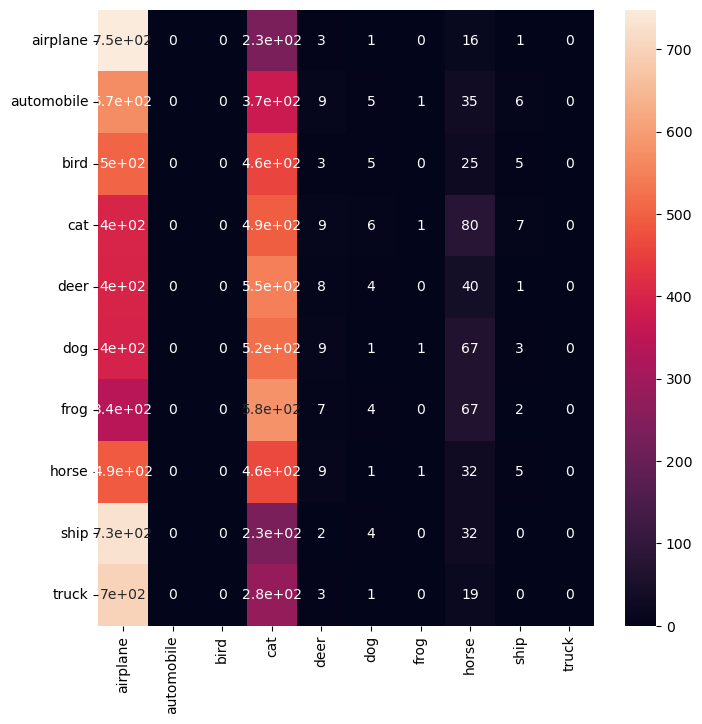

In [45]:
predictions_3  = model_3.predict(X_test)
cm = confusion_matrix(y_test.argmax(1),predictions_3.argmax(1)) #argmax pour one-hot encoding → № de classe
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,  xticklabels=labels, yticklabels = labels);

Visualisation des modèles (texte et graphique):

In [62]:
# À faire

# Apprentissage

In [63]:
# À faire

## Visualisation des résultats

In [63]:
# À faire

# Complexification

On peut continuer à rajouter des couches de convolution :

## Définition

In [65]:
import keras
from keras.models import Sequential
#from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
def build_deeper_model(width, height, depth, n_classes, weight_decay = 1e-4):
    (input_shape, chan_dim) = ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" \
    else ((height, width, depth), -1)
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                     input_shape= input_shape))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    return model

## Instanciation

In [66]:
# À faire

## Visualisation

In [67]:
# À faire

## Apprentissage

In [68]:
# À faire

## Évaluation

In [69]:
# À faire

# Modèles déjà entrainés

On peut trouver un modèle complexe déjà entrainé sur la tâche qui nous intérsse, par exemple [basé sur VGG](https://github.com/geifmany/cifar-vgg) :

In [55]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers import Lambda
from keras import backend as K
from keras import regularizers

class cifar10vgg:
    def __init__(self,train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        else:
            self.model.load_weights('cifar10vgg.h5')


    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model


    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)

    def train(self,model):

        #training parameters
        batch_size = 128
        maxepoches = 250
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20
        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)



        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])


        # training process in a for loop with learning rate drop every 25 epoches.

        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)
        model.save_weights('cifar10vgg.h5')
        return model


## Instanciation 
Il faut avoir le fichier [cifar10vgg.h5](https://drive.google.com/file/d/0B4odNGNGJ56qVW9JdkthbzBsX28/view?usp=sharing&resourcekey=0-4S027Hj5jKjZluUe4rt8IA) dans le répertoire d'exécution du Notebook pour pouvoir instancier le modèle appris.

In [56]:
model_loaded = cifar10vgg(False) 


## Visualisation du modèle

In [70]:
# À faire

## Évaluation

200/200 [==============================] - 35s 174ms/step


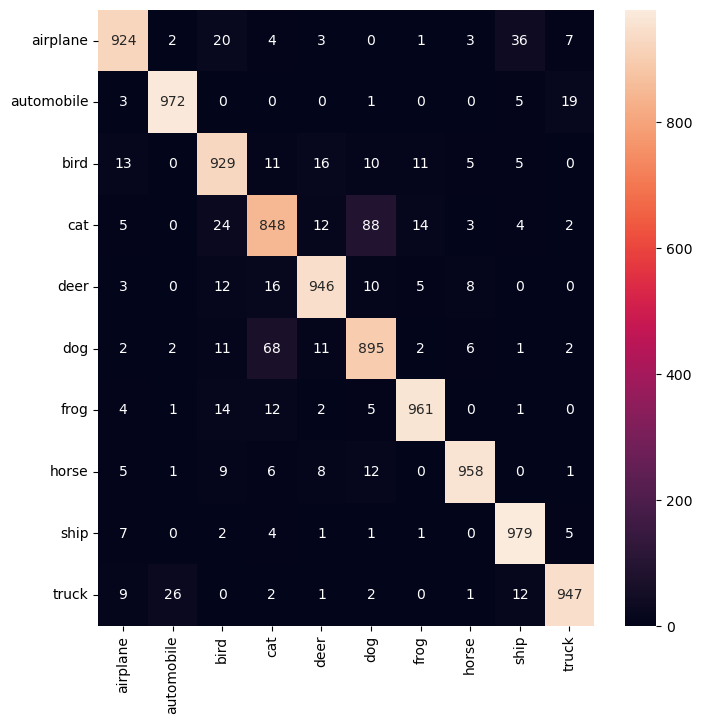

In [58]:
predictions_loaded  = model_loaded.predict(X_test)
cm = confusion_matrix(y_test.argmax(1),predictions_loaded.argmax(1)) #argmax pour one-hot encoding → № de classe
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,  xticklabels=labels, yticklabels = labels, fmt='d');

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, Dropout, Concatenate, add, multiply, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation

class Mish(Activation):
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'

def mish(x):
    return K.minimum(x * K.tanh(K.softplus(x)), 6)

get_custom_objects().update({'mish': Mish(mish)})

def Block(x, f, k):
    if k == 1:
        pad = 'valid'
    else:
        pad = 'same'
    a = BatchNormalization(axis=3)(x)
    a = Conv2D(f, (k, k), use_bias=False, kernel_regularizer=l2(1e-3), padding=pad, kernel_initializer='he_uniform', activation='mish')(a)
    return a

def Inception(x, f):
    a = Block(x = x, f = f//8, k = 1)
    a1 = Block(x = a, f = f//2, k =1)
    a2 = Block(x = a, f = f//2, k = 3)
    a = Concatenate(axis=3)([a1, a2])
    a = Activation('mish')(a)
    b = GlobalAveragePooling2D()(a)
    b = Dense(f//16, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform', activation='mish')(b)
    b = Dense(f, kernel_regularizer=l2(1e-3), activation='sigmoid', kernel_initializer='he_uniform')(b)
    b = multiply([a, b])
    b = Activation('mish')(b)
    return b

def Residual(x, f):
    a = Block(x = x, f = f//8, k = 1)
    a1 = Block(x = a, f = f//2, k =1)
    a2 = Block(x = a, f = f//2, k = 3)
    a = Concatenate(axis=3)([a1, a2])
    a = add([x, a])
    a = Activation('mish')(a)
    b = GlobalAveragePooling2D()(a)
    b = Dense(f//16, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform', activation='mish')(b)
    b = Dense(f, kernel_regularizer=l2(1e-3), activation='sigmoid', kernel_initializer='he_uniform')(b)
    b = multiply([a, b])
    b = add([a, b])
    b = Activation('mish')(b)
    return b

def build_state_of_the_art_model(width, height, depth, n_classes):
#    (input_shape, chan_dim) = ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" else ((height, width, depth), -1)

    inp = tf.keras.Input(shape=(width, height, depth))
    x = BatchNormalization(axis=3)(inp)
    x = Conv2D(96, (3,3), padding='same', use_bias=False, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform', activation='mish')(x)

    x = Inception(x, 192)
    x = Residual(x, 192)
    x = Inception(x, 288)
    x = Residual(x, 288)
    x = Inception(x, 384)
    x = Residual(x, 384)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    x = Inception(x, 480)
    x = Residual(x, 480)
    x = Inception(x, 576)
    x = Residual(x, 576)
    x = Inception(x, 672)
    x = Residual(x, 672)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)

    x = BatchNormalization(axis=3)(x)
    x = Conv2D(816, (1,1), use_bias=False, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform', activation='mish')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(10, activation='softmax')(x)

    return tf.keras.Model(inp, x, name='ElNet')

# Bonus

Essayer d'autres modèles :

- [état de l'art en 2022](https://github.com/Adeel-Intizar/CIFAR-10-State-of-the-art-Model/blob/master/CIFAR-10%20Best.ipynb))
- [Resnet](https://keras.io/zh/examples/cifar10_resnet/)

## Utiliser un modèle existant déjà entrainé pour faire du transfert learning

Instancier, et compiler un modèle basé sur un modèle déjà existant (et entrainé !). Si vous utilisez `VGG16`, il faut alors redimensionner les images car ce modèle requiert des images d'au moins `48×48` :

In [ ]:
from skimage.transform import resize
X_train_resized = np.array([resize(image, (48,48)) for image in X_train])
X_test_resized = np.array([resize(image, (48,48)) for image in X_test])

Apprendre ce modèle sur un générateur basé sur `X_train_resized`,`y_train` en le validant sur `X_test_resized`, `y_test`. (Ne le faire que pour quelques *epochs* pour des questions de temps !) et récupérant l'historique de l'apprentissage.
Visualiser l'évolution de `loss` et `accuracy`.

In [57]:
# TODO

In [58]:
# TODO

In [59]:
# TODO